In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
from mumu.feature._woe import catwoe_autobinning, catwoe_aptbinning, catwoe_apply
from mumu.feature._woe import numwoe_autobinning, numwoe_aptbinning, numwoe_apply
from mumu.model._evaluate import plot_all, plot_ks_auc, plot_slopping, plot_score_dist

In [2]:
df = pd.read_csv("../data/train.csv")
df_oot = pd.read_csv("../data/oot.csv")

# 处理缺失值

In [3]:
num_cols = [
    'nv_var1', 'nv_var2', 'nv_var3', 'nv_var4',
    'nv_var5','nv_var6', 'nv_var7', 'nv_var8',
    'nv_var9', 'nv_var10', 'nv_var11'
]

cat_cols = ['cv_var12']

for col in num_cols:
    df[col] = df[col].fillna(-1).astype(float)
    df_oot[col] = df_oot[col].fillna(-1).astype(float)


for col in cat_cols:
    df[col] = df[col].fillna('-1').astype(str)
    df_oot[col] = df_oot[col].fillna('-1').astype(str)

In [4]:
df_is, df_oos = train_test_split(df, test_size=0.2, random_state=42, shuffle=True, stratify=df['target'])

In [5]:
df.head()

,id,dt,target,nv_var1,nv_var2,nv_var3,nv_var4,nv_var5,nv_var6,nv_var7,nv_var8,nv_var9,nv_var10,nv_var11,cv_var12
0,61706150,2020-06-01,0,1.0,118.0,-1.0,0.675926,0.0,0.0,0.0,22.017859,-1.0,97.83,681.41,广东
1,61881237,2020-06-01,0,4.0,141.0,-1.0,0.458333,0.0,1.0,0.0,22.415116,-1.0,803.60,840.32,安徽
2,61804249,2020-06-01,0,17.0,41.0,-1.0,0.684343,0.0,1.0,0.0,128.078970,-1.0,141.05,1646.59,陕西
3,61982386,2020-06-01,0,21.0,1024.0,-1.0,0.888889,0.0,0.0,-1.0,-1.000000,-1.0,768.14,768.14,-1
4,61860869,2020-06-01,1,4.0,93.0,-1.0,0.785088,0.0,1.0,0.0,34.893275,-1.0,141.09,1322.06,江苏


# 计算变量的 IV 值

In [6]:
def num_cols_iv_table(data, num_columns):

    iv_cols = []

    for col in num_columns:
        try:
            data[col].fillna(-1, inplace=True)
            data[col] = data[col].astype(float)

            df_col_iv = numwoe_autobinning(df_master=data, var_name=col, target='target', to_plot=False)

            iv_cols.append([col, df_col_iv['IV'].unique()[0]])
            print(col, df_col_iv['IV'].unique()[0])
        except Exception:
            print(col)

    df_iv = pd.DataFrame(iv_cols, columns=['col', 'iv']).sort_values(by='iv')
    return df_iv


def cat_cols_iv_table(data, cat_columns):

    iv_cols = []

    for col in cat_columns:
        try:
            # data[col].fillna('-1', inplace=True)
            data[col] = data[col].astype(str)

            df_col_iv = catwoe_autobinning(df_master=data, var_name=col, target='target', to_plot=False, max_bins=10)

            iv_cols.append([col, df_col_iv['IV'].unique()[0]])
            print(col, df_col_iv['IV'].unique()[0])
        except Exception:
            print(col)

    df_iv = pd.DataFrame(iv_cols, columns=['col', 'iv']).sort_values(by='iv')
    return df_iv

In [7]:
df_cat_vars_iv = cat_cols_iv_table(df[cat_cols + ['target']], cat_cols)
df_cat_vars_iv

cv_var12 0.027916972637954025


,col,iv
0,cv_var12,0.027917


In [8]:
df_num_vars_iv = num_cols_iv_table(df[num_cols + ['target']], num_cols)
df_num_vars_iv

nv_var1 0.49158109858797083
nv_var2 0.3716062420969449


nv_var3 0.15993711597849763


nv_var4 0.0226736417132671
nv_var5 0.021682375667959303
nv_var6 0.012147113905421905
nv_var7 0.0887360607361448
nv_var8 0.1272494779911793
nv_var9 0.2441159434424728
nv_var10 0.07306145344927092
nv_var11 0.007006395731650687


,col,iv
10,nv_var11,0.007006
5,nv_var6,0.012147
4,nv_var5,0.021682
3,nv_var4,0.022674
9,nv_var10,0.073061
6,nv_var7,0.088736
7,nv_var8,0.127249
2,nv_var3,0.159937
8,nv_var9,0.244116
1,nv_var2,0.371606


# 查看单个变量的 WOE 和 IV 表现

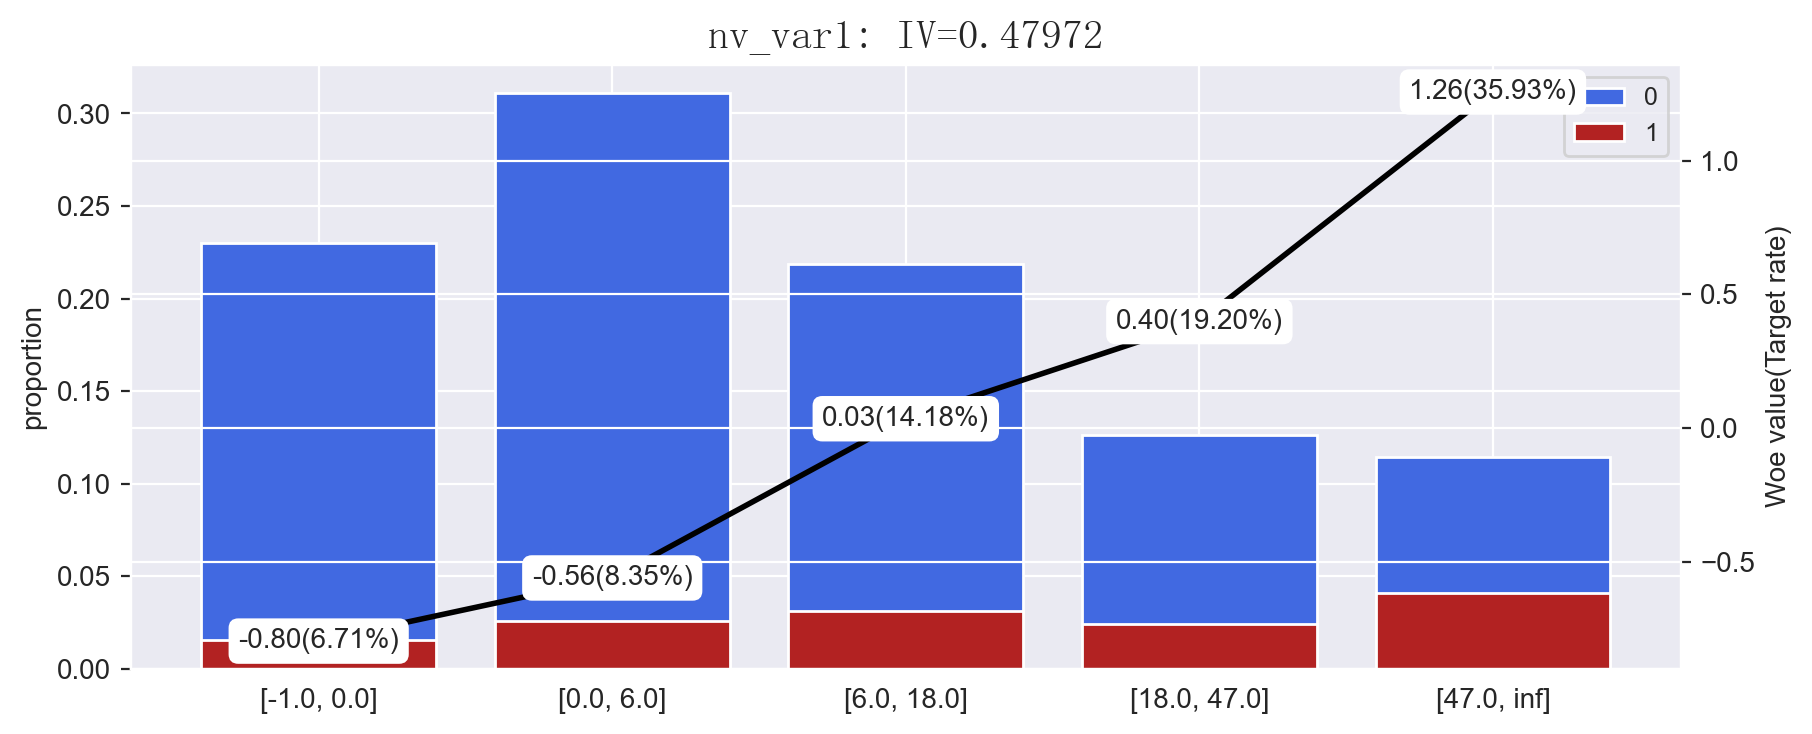

,Var_Name,Var_Type,Bin_No,Var_Value,Ref_Value,Count_0,Count_1,Total,Target_Rate,Proportion,IV
0,nv_var1,numerical,1,"[-1.0, 0.0]",-0.797194,11817.0,850.0,12667.0,0.067103,0.230075,0.479717
1,nv_var1,numerical,2,"[0.0, 6.0]",-0.561057,15688.0,1429.0,17117.0,0.083484,0.310902,0.479717
2,nv_var1,numerical,3,"[6.0, 18.0]",0.034544,10324.0,1706.0,12030.0,0.141812,0.218505,0.479717
3,nv_var1,numerical,4,"[18.0, 47.0]",0.397857,5622.0,1336.0,6958.0,0.192009,0.126380,0.479717
4,nv_var1,numerical,5,"[47.0, inf]",1.256570,4026.0,2258.0,6284.0,0.359325,0.114138,0.479717


In [9]:
numwoe_autobinning(df_is, var_name='nv_var1', target='target')

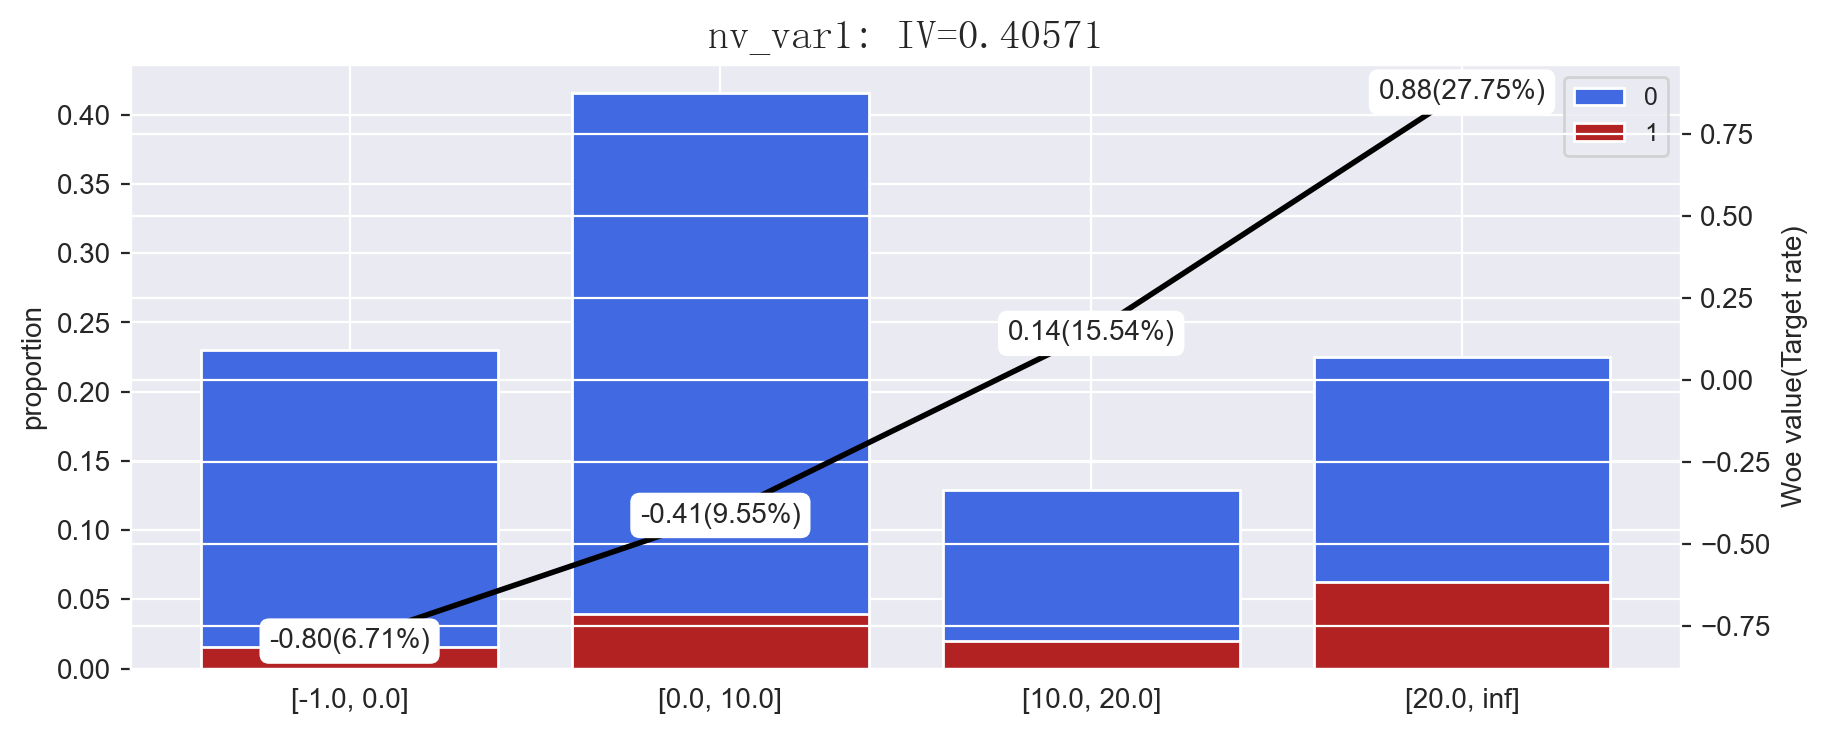

,Var_Name,Var_Type,Bin_No,Var_Value,Ref_Value,Count_0,Count_1,Total,Target_Rate,Proportion,IV
0,nv_var1,numerical,1,"[-1, 0]",-0.797194,11817,850,12667,0.067103,0.230075,0.405713
1,nv_var1,numerical,2,"[0, 10]",-0.413822,20694,2184,22878,0.095463,0.415541,0.405713
2,nv_var1,numerical,3,"[10, 20]",0.141690,6013,1106,7119,0.155359,0.129305,0.405713
3,nv_var1,numerical,4,"[20, inf]",0.878056,8953,3439,12392,0.277518,0.225080,0.405713


In [10]:
numwoe_aptbinning(df_is, var_name='nv_var1', bins=[-1, 0, 10, 20, np.inf], target="target")

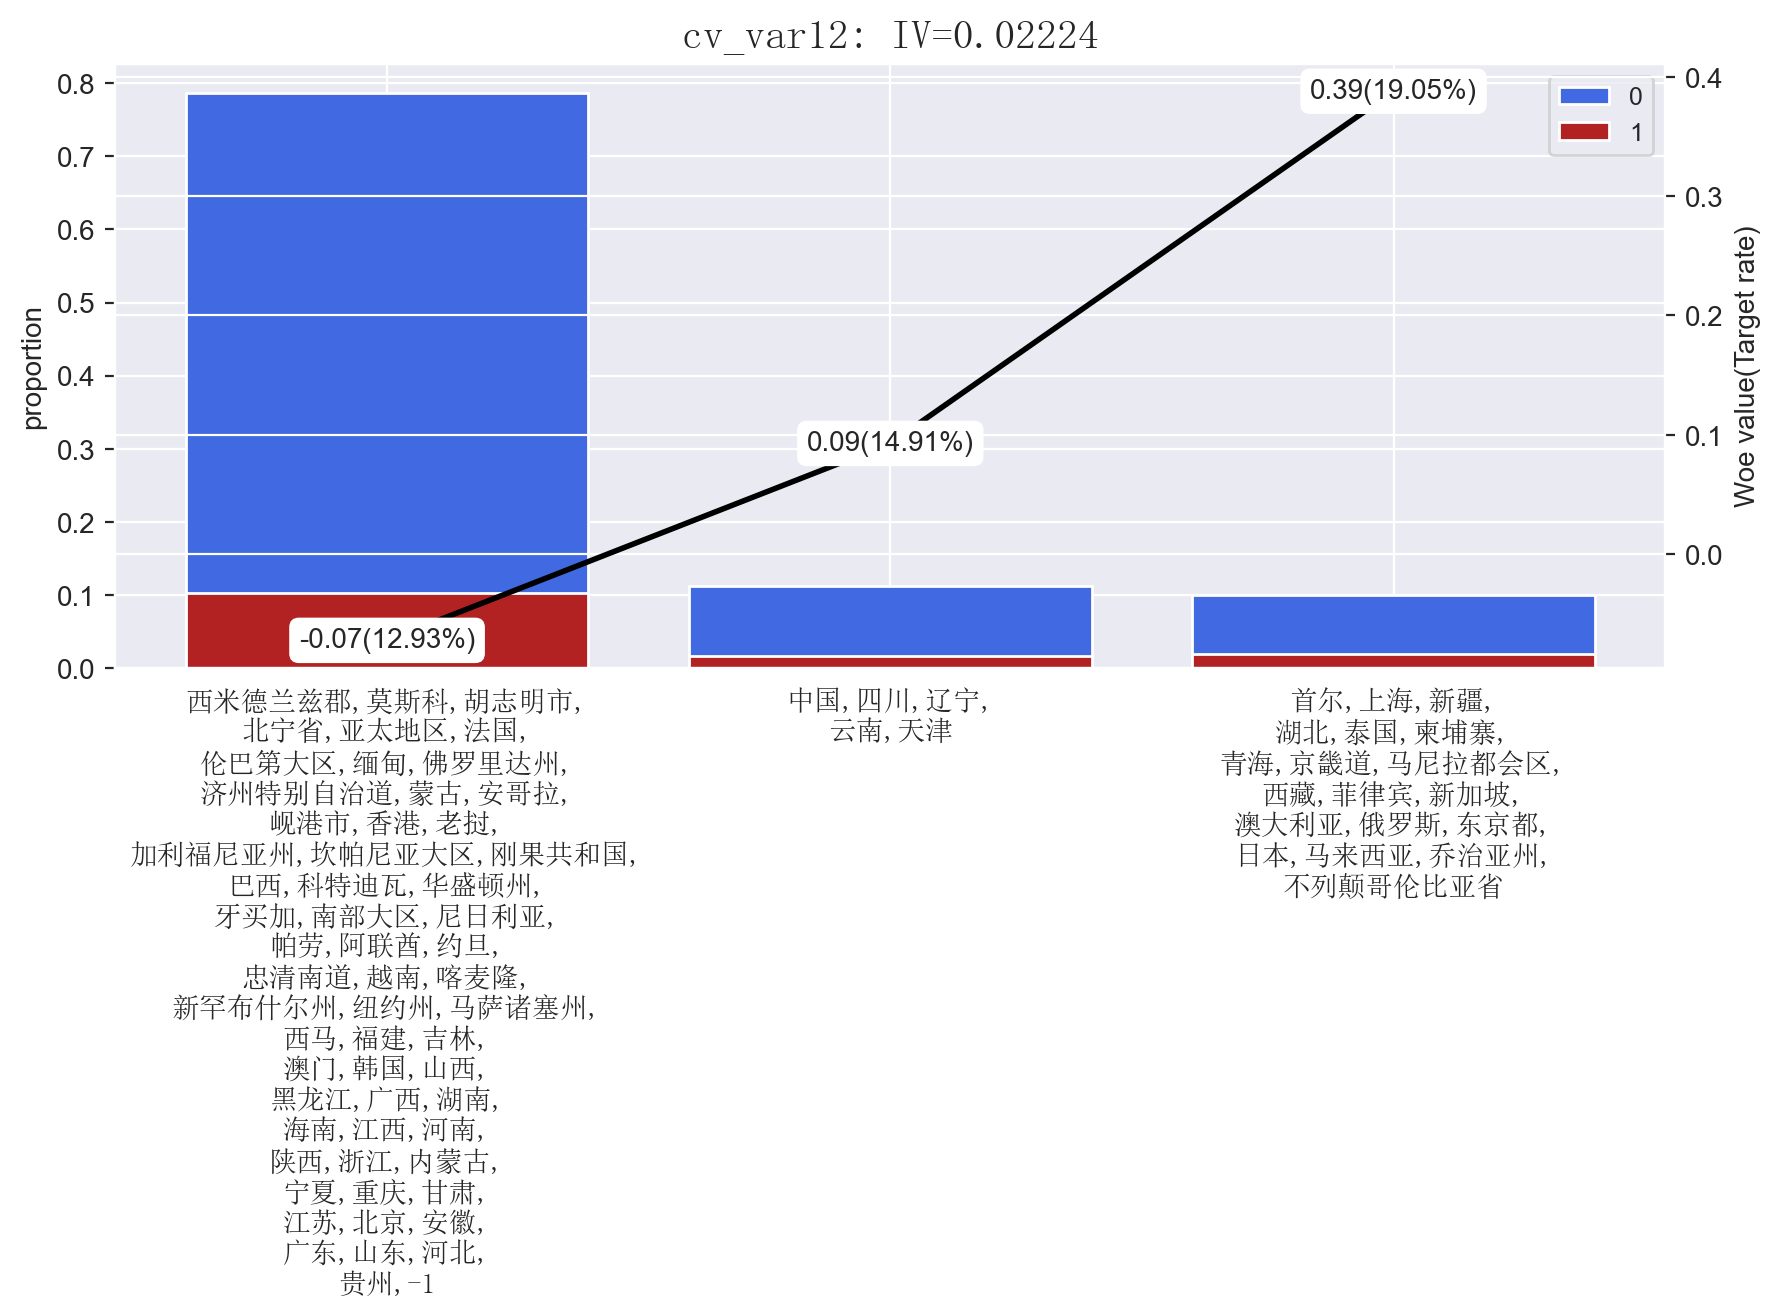

,Var_Name,Var_Type,Bin_No,Var_Value,Ref_Value,Count_0,Count_1,Total,Target_Rate,Proportion,IV
0,cv_var12,categorical,1,西米德兰兹郡莫斯科胡志明市北宁省亚太地区法国伦巴第大区缅甸佛罗里达州济州特...,-0.072098,37743,5606,43349,0.129322,0.787362,0.022243
1,cv_var12,categorical,2,中国四川辽宁云南天津,0.092842,5275,924,6199,0.149056,0.112594,0.022243
2,cv_var12,categorical,3,首尔上海新疆湖北泰国柬埔寨青海京畿道马尼拉都会区西藏菲律宾新加坡澳大...,0.387777,4459,1049,5508,0.190450,0.100044,0.022243


In [11]:
catwoe_autobinning(df_is, var_name='cv_var12', target='target')

# 变量 WOE 化

In [12]:
def num_cols_woe_ref_table(data, num_columns):

    woe_ref_table = []

    for col in num_columns:
        try:
            data[col].fillna(-1, inplace=True)
            data[col] = data[col].astype(float)

            df_col_iv = numwoe_autobinning(df_master=data, var_name=col, target='target', to_plot=False, max_bins=5)
            woe_ref_table.append(df_col_iv)
        except Exception:
            print(col)

    df_iv = pd.concat(woe_ref_table)
    return df_iv


def cat_cols_woe_ref_table(data, cat_columns):

    woe_ref_table = []

    for col in cat_columns:
        try:
            data[col].fillna('-1', inplace=True)
            data[col] = data[col].astype(str)

            df_col_iv = catwoe_autobinning(df_master=data, var_name=col, target='target', to_plot=False, max_bins=5)
            woe_ref_table.append(df_col_iv)
        except Exception:
            print(col)

    df_iv = pd.concat(woe_ref_table)
    return df_iv

In [13]:
df_cat_ref_table = cat_cols_woe_ref_table(df_is, cat_cols)
df_cat_ref_table

,Var_Name,Var_Type,Bin_No,Var_Value,Ref_Value,Count_0,Count_1,Total,Target_Rate,Proportion,IV
0,cv_var12,categorical,1,西米德兰兹郡莫斯科胡志明市北宁省亚太地区法国伦巴第大区缅甸佛罗里达州济州特...,-0.072098,37743,5606,43349,0.129322,0.787362,0.022243
1,cv_var12,categorical,2,中国四川辽宁云南天津,0.092842,5275,924,6199,0.149056,0.112594,0.022243
2,cv_var12,categorical,3,首尔上海新疆湖北泰国柬埔寨青海京畿道马尼拉都会区西藏菲律宾新加坡澳大...,0.387777,4459,1049,5508,0.190450,0.100044,0.022243


In [14]:
df_num_ref_table = num_cols_woe_ref_table(df_is, num_cols)
df_num_ref_table

,Var_Name,Var_Type,Bin_No,Var_Value,Ref_Value,Count_0,Count_1,Total,Target_Rate,Proportion,IV
0,nv_var1,numerical,1,"[-1.0, 0.0]",-0.797194,11817.0,850.0,12667.0,0.067103,0.230075,0.479717
1,nv_var1,numerical,2,"[0.0, 6.0]",-0.561057,15688.0,1429.0,17117.0,0.083484,0.310902,0.479717
2,nv_var1,numerical,3,"[6.0, 18.0]",0.034544,10324.0,1706.0,12030.0,0.141812,0.218505,0.479717
3,nv_var1,numerical,4,"[18.0, 47.0]",0.397857,5622.0,1336.0,6958.0,0.192009,0.126380,0.479717
4,nv_var1,numerical,5,"[47.0, inf]",1.256570,4026.0,2258.0,6284.0,0.359325,0.114138,0.479717
0,nv_var2,numerical,1,"[-1.0, 0.0]",-0.040094,476.0,73.0,549.0,0.132969,0.009972,0.360880
1,nv_var2,numerical,2,"[0.0, 22.0]",0.873443,7433.0,2842.0,10275.0,0.276594,0.186628,0.360880
2,nv_var2,numerical,3,"[22.0, 46.0]",0.312562,6700.0,1462.0,8162.0,0.179123,0.148249,0.360880
3,nv_var2,numerical,4,"[46.0, 80.0]",-0.207339,8856.0,1149.0,10005.0,0.114843,0.181724,0.360880
4,nv_var2,numerical,5,"[80.0, inf]",-0.624387,24012.0,2053.0,26065.0,0.078765,0.473427,0.360880


In [15]:
for cat_col in cat_cols:
    df_is[cat_col].fillna('-1', inplace=True)
    df_oos[cat_col].fillna('-1', inplace=True)
    catwoe_apply(df_master=df_is, ref_table=df_cat_ref_table.loc[df_cat_ref_table['Var_Name'] == cat_col], var_name=cat_col)
    catwoe_apply(df_master=df_oos, ref_table=df_cat_ref_table.loc[df_cat_ref_table['Var_Name'] == cat_col], var_name=cat_col)

    df_oot[cat_col].fillna('-1', inplace=True)
    catwoe_apply(df_master=df_oot, ref_table=df_cat_ref_table.loc[df_cat_ref_table['Var_Name'] == cat_col], var_name=cat_col)

In [16]:
for num_col in num_cols:
    df_is[num_col].fillna(-1, inplace=True)
    df_oos[num_col].fillna(-1, inplace=True)
    numwoe_apply(df_master=df_is, ref_table=df_num_ref_table.loc[df_num_ref_table['Var_Name'] == num_col], var_name=num_col)
    numwoe_apply(df_master=df_oos, ref_table=df_num_ref_table.loc[df_num_ref_table['Var_Name'] == num_col], var_name=num_col)

    df_oot[num_col].fillna(-1, inplace=True)
    numwoe_apply(df_master=df_oot, ref_table=df_num_ref_table.loc[df_num_ref_table['Var_Name'] == num_col], var_name=num_col)

In [17]:
df_is.head()

,id,dt,target,nv_var1,nv_var2,nv_var3,nv_var4,nv_var5,nv_var6,nv_var7,...,nwoe_nv_var2,nwoe_nv_var3,nwoe_nv_var4,nwoe_nv_var5,nwoe_nv_var6,nwoe_nv_var7,nwoe_nv_var8,nwoe_nv_var9,nwoe_nv_var10,nwoe_nv_var11
40229,62420503,2020-06-01,0,-1.0,110.0,-1.0,0.833333,0.0,0.0,0.0,...,-0.624387,-0.122318,0.144563,-0.036706,-0.174219,-0.068782,-0.243060,-0.126132,-0.378893,-0.066354
55692,62019570,2020-06-01,0,1.0,101.0,-1.0,0.625000,0.0,2.0,0.0,...,-0.624387,-0.122318,-0.074497,-0.036706,0.102425,-0.068782,-0.013664,-0.126132,-0.134210,0.011049
49895,62081553,2020-06-01,1,7.0,107.0,-1.0,0.611111,0.0,2.0,0.0,...,-0.624387,-0.122318,-0.074497,-0.036706,0.102425,-0.068782,0.384375,-0.126132,-0.378893,-0.066354
19145,62517541,2020-06-01,0,1.0,85.0,-1.0,0.777778,0.0,1.0,0.0,...,-0.624387,-0.122318,0.020604,-0.036706,0.035265,-0.068782,-0.509467,-0.126132,0.121656,-0.066354
28415,62655886,2020-06-01,1,20.0,18.0,-1.0,0.875000,0.0,1.0,0.0,...,0.873443,-0.122318,0.144563,-0.036706,0.035265,-0.068782,-0.013664,-0.126132,0.121656,0.011049


# 计算相关性

In [18]:
df[num_cols].corr()

,nv_var1,nv_var2,nv_var3,nv_var4,nv_var5,nv_var6,nv_var7,nv_var8,nv_var9,nv_var10,nv_var11
nv_var1,1.000000,-0.150779,0.099656,0.147144,0.056081,0.036703,0.162537,0.220365,0.336464,-0.124095,-0.014844
nv_var2,-0.150779,1.000000,-0.043421,0.009830,-0.047535,-0.055294,-0.143846,-0.394971,-0.082134,0.077903,-0.021216
nv_var3,0.099656,-0.043421,1.000000,0.004991,0.014936,0.028844,0.037258,0.015398,0.046853,-0.048883,0.017071
nv_var4,0.147144,0.009830,0.004991,1.000000,0.045064,0.005271,0.011339,0.011355,0.023101,-0.015413,0.014382
nv_var5,0.056081,-0.047535,0.014936,0.045064,1.000000,-0.007102,0.028871,0.040881,0.086989,-0.013907,0.109155
nv_var6,0.036703,-0.055294,0.028844,0.005271,-0.007102,1.000000,-0.012647,0.010292,0.019483,-0.078596,0.012102
nv_var7,0.162537,-0.143846,0.037258,0.011339,0.028871,-0.012647,1.000000,0.124821,0.160693,-0.033451,0.009396
nv_var8,0.220365,-0.394971,0.015398,0.011355,0.040881,0.010292,0.124821,1.000000,0.089865,0.023520,0.015881
nv_var9,0.336464,-0.082134,0.046853,0.023101,0.086989,0.019483,0.160693,0.089865,1.000000,-0.030325,0.064557
nv_var10,-0.124095,0.077903,-0.048883,-0.015413,-0.013907,-0.078596,-0.033451,0.023520,-0.030325,1.000000,0.489021


In [19]:
woe_cat_cols = ['cwoe_' + col for col in cat_cols]
woe_num_cols = ['nwoe_' + col for col in num_cols]
woe_model_cols = woe_cat_cols + woe_num_cols

In [20]:
df_is[woe_model_cols].corr()

,cwoe_cv_var12,nwoe_nv_var1,nwoe_nv_var2,nwoe_nv_var3,nwoe_nv_var4,nwoe_nv_var5,nwoe_nv_var6,nwoe_nv_var7,nwoe_nv_var8,nwoe_nv_var9,nwoe_nv_var10,nwoe_nv_var11
cwoe_cv_var12,1.000000,0.008260,0.034282,0.013387,0.002691,-0.003558,0.005932,0.005575,0.011655,0.020684,0.000045,-0.017352
nwoe_nv_var1,0.008260,1.000000,0.273162,0.349311,0.193270,0.054006,0.031096,0.144196,0.222083,0.340860,0.209783,0.076741
nwoe_nv_var2,0.034282,0.273162,1.000000,0.202818,0.037246,0.123762,0.040120,0.298736,0.455634,0.264932,0.103883,-0.008738
nwoe_nv_var3,0.013387,0.349311,0.202818,1.000000,0.040494,0.050136,0.032884,0.134811,0.064695,0.318012,0.192700,0.019599
nwoe_nv_var4,0.002691,0.193270,0.037246,0.040494,1.000000,0.011086,-0.035413,0.017278,0.008713,0.028557,0.097036,0.090557
nwoe_nv_var5,-0.003558,0.054006,0.123762,0.050136,0.011086,1.000000,0.007372,0.074917,0.067760,0.152842,0.119431,-0.068074
nwoe_nv_var6,0.005932,0.031096,0.040120,0.032884,-0.035413,0.007372,1.000000,-0.067885,-0.013236,0.027532,0.067287,0.035454
nwoe_nv_var7,0.005575,0.144196,0.298736,0.134811,0.017278,0.074917,-0.067885,1.000000,0.126224,0.251017,0.042656,-0.014880
nwoe_nv_var8,0.011655,0.222083,0.455634,0.064695,0.008713,0.067760,-0.013236,0.126224,1.000000,0.108408,-0.055500,-0.032646
nwoe_nv_var9,0.020684,0.340860,0.264932,0.318012,0.028557,0.152842,0.027532,0.251017,0.108408,1.000000,0.133671,0.002723


# 共线性

VIF 越大，则表示该变量与其他变量的共线程度越高，当 VIF > 10 或者 AVG(VIF) > 1 则可以认为该变量共线程度比较高。

In [21]:
for i in range(len(num_cols)):
    print(num_cols[i], variance_inflation_factor(df_is[num_cols].fillna(-1).values, i))

nv_var1 1.7004876923336842
nv_var2 2.3534506480724056
nv_var3 1.0153713081566864
nv_var4 6.743035408707999
nv_var5 1.050996938081037
nv_var6 1.894219743026228
nv_var7 1.068418134161084
nv_var8 2.995853315948642
nv_var9 1.1664783652652224
nv_var10 2.3491639588470385
nv_var11 3.4148880230543663


In [22]:
for i in range(len(woe_model_cols)):
    print(woe_model_cols[i], variance_inflation_factor(df_is[woe_model_cols].fillna(-1).values, i))

cwoe_cv_var12 1.0027562362460076
nwoe_nv_var1 1.4109286356466328
nwoe_nv_var2 1.52185793933044
nwoe_nv_var3 1.251913309806281
nwoe_nv_var4 1.05427745573951
nwoe_nv_var5 1.0621440464501637
nwoe_nv_var6 1.0181641393269765
nwoe_nv_var7 1.1586166742588677
nwoe_nv_var8 1.334262426293866
nwoe_nv_var9 1.308443448508936
nwoe_nv_var10 1.3474463378521038
nwoe_nv_var11 1.235246171122931


# 训练 LR 模型

In [24]:
df_is['const'] = 1
df_oos['const'] = 1
df_oot['const'] = 1

In [25]:
model_cols = woe_model_cols + ["const"]
logit = sm.Logit(df_is['target'], df_is[model_cols])
result = logit.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.356199
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                         Results: Logit
=================================================================
Model:              Logit            Pseudo R-squared: 0.111     
Dependent Variable: target           AIC:              39247.8179
Date:               2022-07-19 16:40 BIC:              39363.7273
No. Observations:   55056            Log-Likelihood:   -19611.   
Df Model:           12               LL-Null:          -22061.   
Df Residuals:       55043            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-----------------------------------------------------------------
                 Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
cwoe_cv_var12    0.9500   0.0847   11.2224 0.0000  0.7841  1.1160
nwoe_nv_var1     0.6627   0.0208   31.9124 0.0000  0.6220  0.7034
nwoe_nv_var2     0.5884   0.0257   22.9203 0.0000  0.5380  0.6387
nwoe_nv_var3     0.1881   0.0334    5.6235 0.0000  0.1225  0.2537
nwoe_nv_var4     0.2409   0.0997    2.4164 0.0157  0.0455  0.4364
nwoe_nv_var5     0.2789   0.0883    3.1599 0.0016  0.1059  0.4519
nwoe_nv_var6     0.7284   0.1206    6.0383 0.0000  0.4920  0.9649
nwoe_nv_var7     0.2266   0.0426    5.3145 0.0000  0.1430  0.3101
nwoe_nv_var8     0.1823   0.0428    4.2580 0.0000  0.0984  0.2661
nwoe_nv_var9     0.3026   0.0271   11.1759 0.0000  0.2495  0.3556
nwoe_nv_var10    0.2749   0.0557    4.9354 0.0000  0.1658  0.3841
nwoe_nv_var11    0.4000   0.1741    2.2982 0.0216  0.0589  0.7412
const           -1.8243   0.0134 -135.9007 0.0000 -1.8506 -1.7980
=================================================================

"""

# 模型评价

In [29]:
df_is['score'] = result.predict(df_is[model_cols])
df_oos['score'] = result.predict(df_oos[model_cols])
df_oot['score'] = result.predict(df_oot[model_cols])

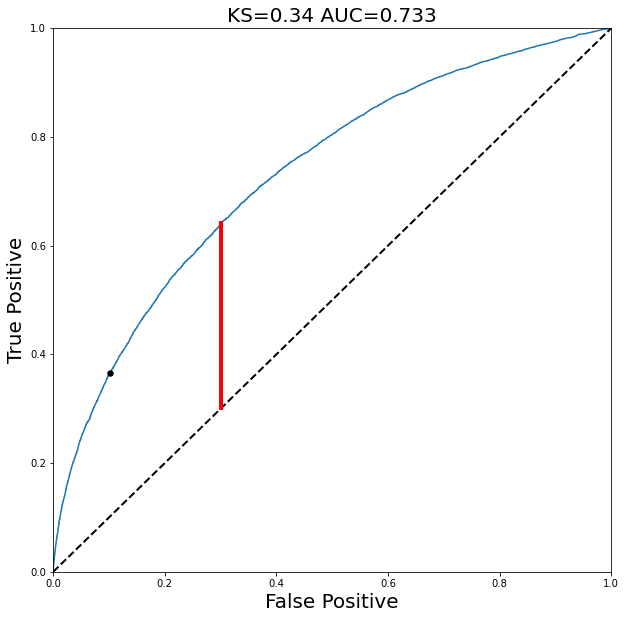

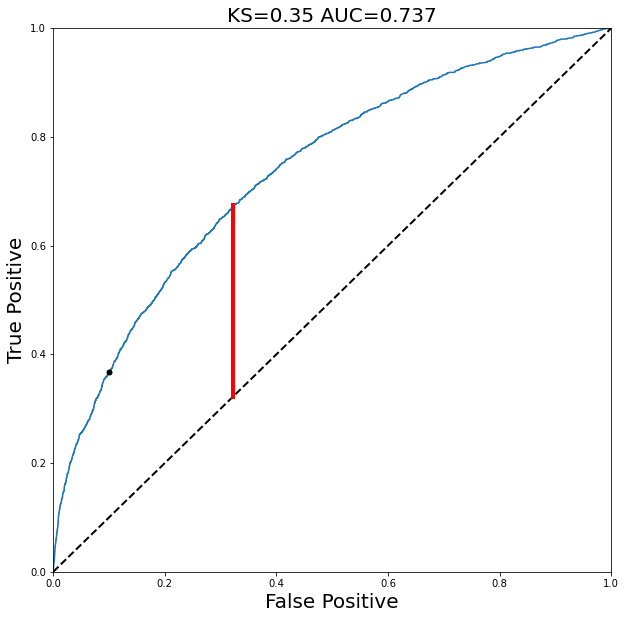

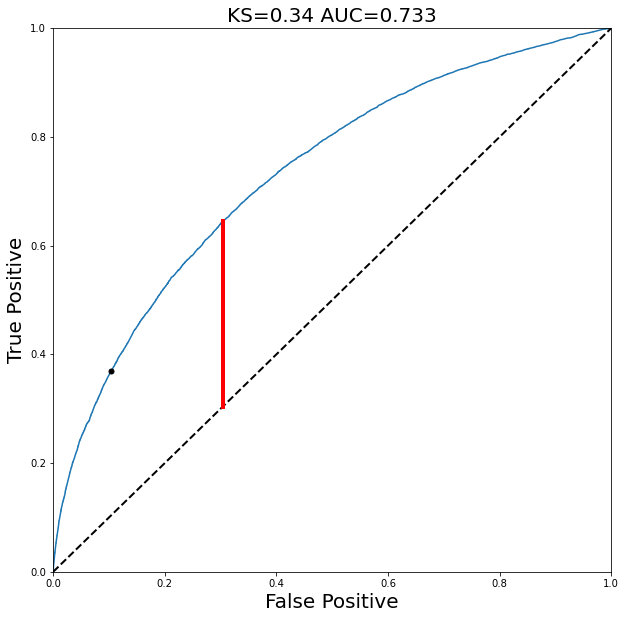

In [33]:
is_auc = plot_ks_auc(target=df_is['target'].reset_index(drop=True), predicted=df_is['score'].reset_index(drop=True))
oos_auc = plot_ks_auc(target=df_oos['target'].reset_index(drop=True), predicted=df_oos['score'].reset_index(drop=True))
oot_auc = plot_ks_auc(target=df_oot['target'].reset_index(drop=True), predicted=df_oot['score'].reset_index(drop=True))

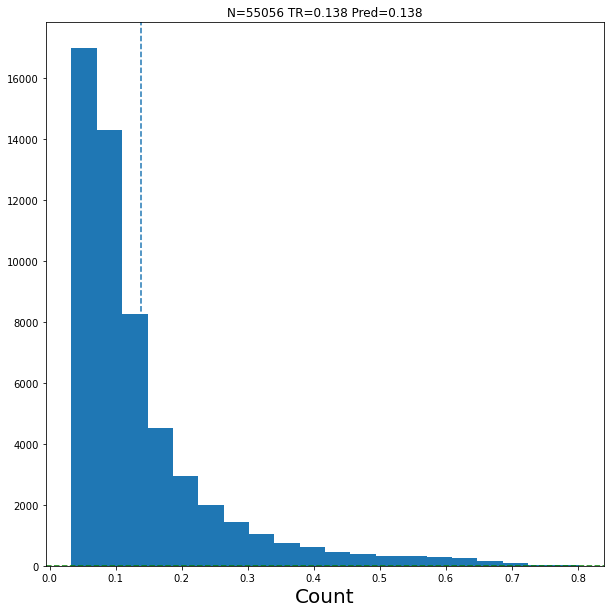

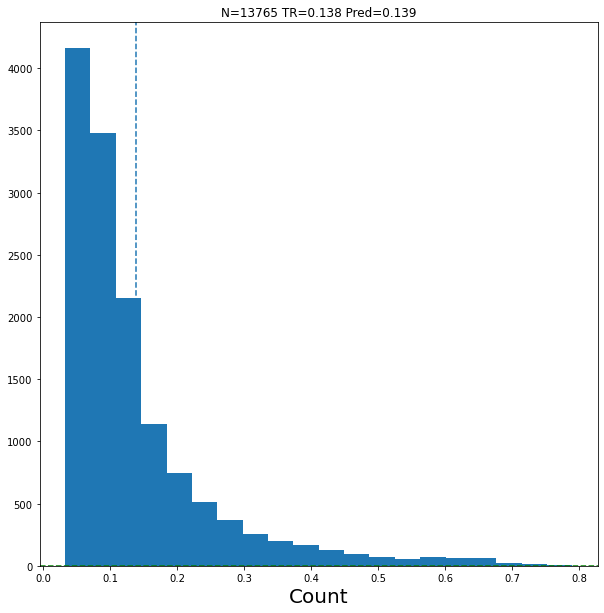

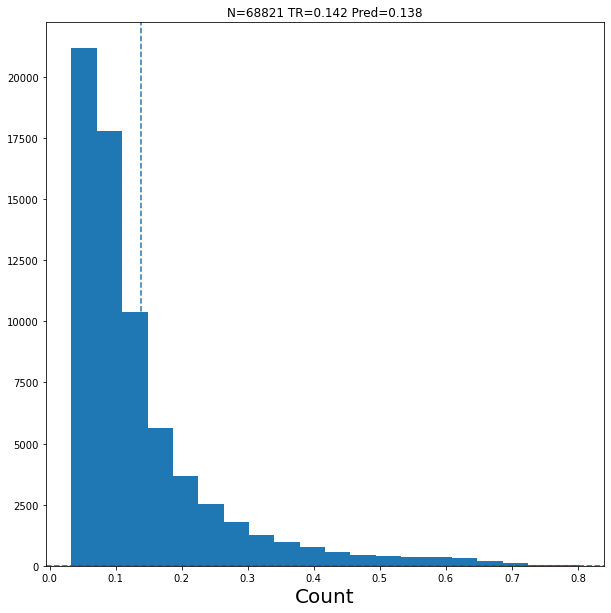

In [34]:
is_score_dist = plot_score_dist(target=df_is['target'].reset_index(drop=True), predicted=df_is['score'].reset_index(drop=True))
oos_score_dist = plot_score_dist(target=df_oos['target'].reset_index(drop=True), predicted=df_oos['score'].reset_index(drop=True))
oot_score_dist = plot_score_dist(target=df_oot['target'].reset_index(drop=True), predicted=df_oot['score'].reset_index(drop=True))

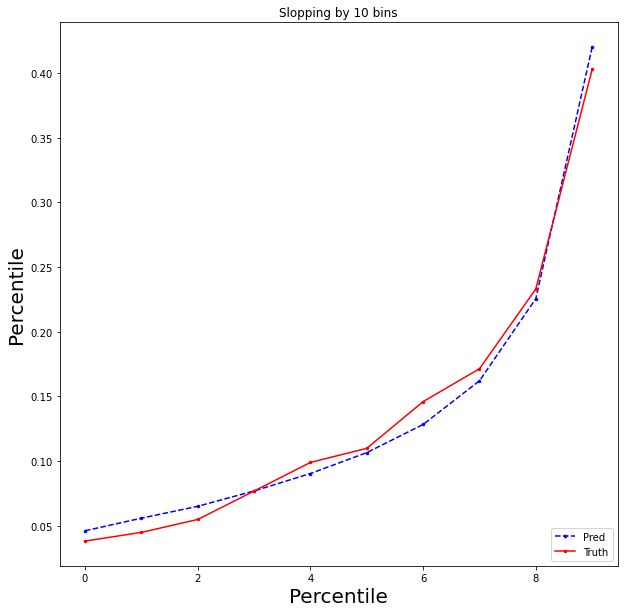

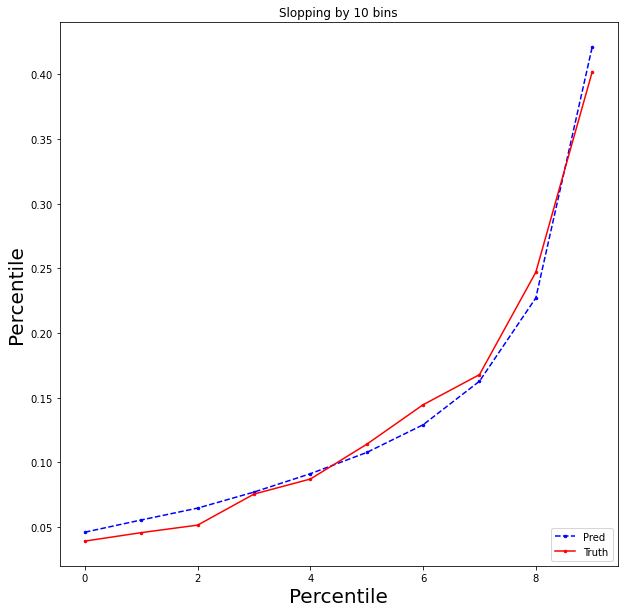

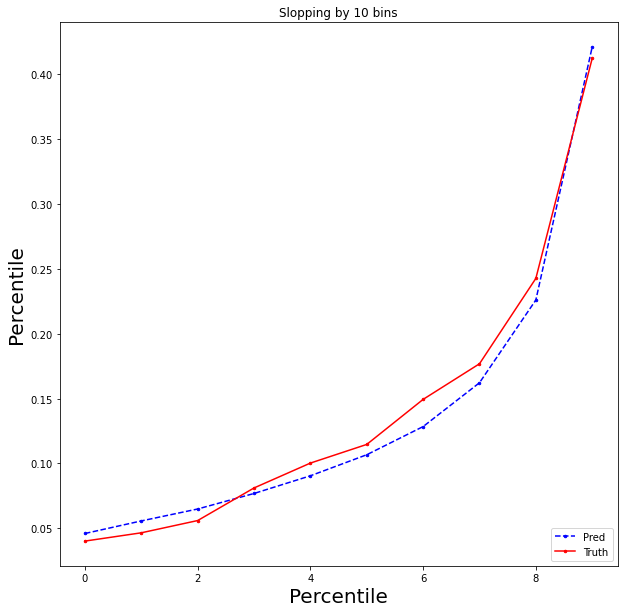

In [35]:
is_slopping = plot_slopping(target=df_is['target'].reset_index(drop=True), predicted=df_is['score'].reset_index(drop=True))
oos_slopping = plot_slopping(target=df_oos['target'].reset_index(drop=True), predicted=df_oos['score'].reset_index(drop=True))
oot_slopping = plot_slopping(target=df_oot['target'].reset_index(drop=True), predicted=df_oot['score'].reset_index(drop=True))

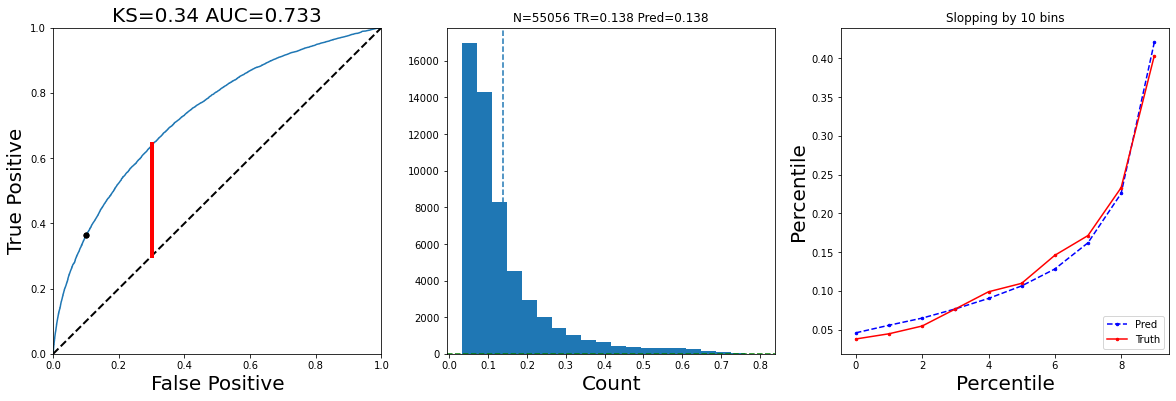

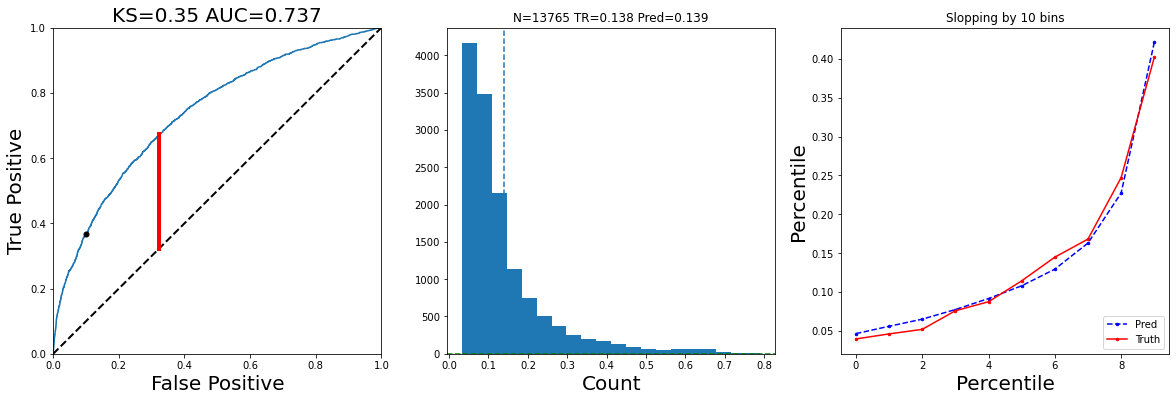

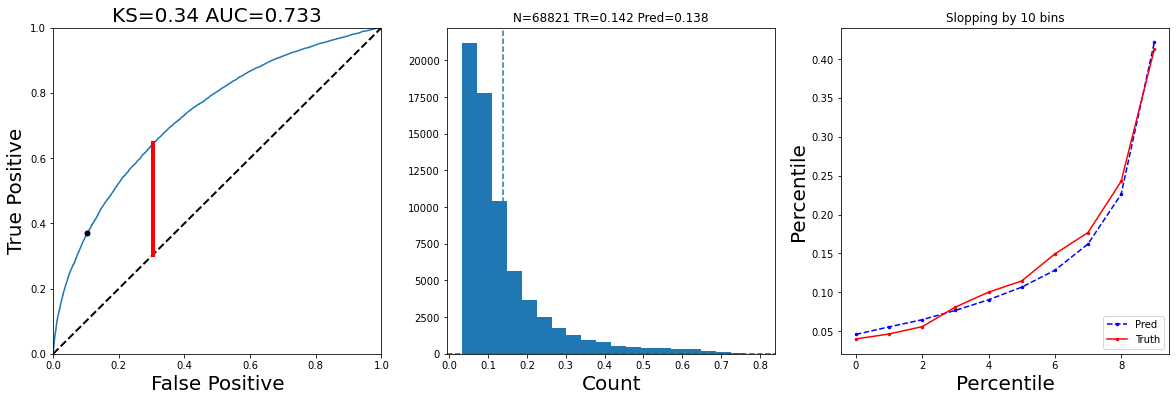

In [37]:
is_plot = plot_all(target=df_is['target'].reset_index(drop=True), predicted=df_is['score'].reset_index(drop=True))
oos_plot = plot_all(target=df_oos['target'].reset_index(drop=True), predicted=df_oos['score'].reset_index(drop=True))
oot_plot = plot_all(target=df_oot['target'].reset_index(drop=True), predicted=df_oot['score'].reset_index(drop=True))